In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical as emp
from tqdm import trange, tqdm
import time
sns.set_style('darkgrid')

#model to use
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, loguniform

# SHAP
import shap

# skfolio allocation (tangency / mean-variance)
from skfolio.optimization import MeanRisk

#for warning filtering
from warnings import filterwarnings
filterwarnings("ignore")

#Exporting The model
import pickle


## Variables that we will be needing since our Heston Model is modified to have Transactions since it's limitations is that it assumes that every trade there is no Transaction Cost

In [4]:
TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
START = "2018-01-01"
END = datetime.today().strftime("%Y-%m-%d")
LOOKBACK_COV = 60            # days used to compute covariance matrix
FEATURE_RV_WINDOWS = [5, 10, 21]
RANDOM_SEARCH_ITERS = 10     # randomized search iterations (increase for better tuning)
N_TS_SPLITS = 3
PF_PARTICLES = 200           # particle filter particles (increase for accuracy; increases compute)
PF_CALIBRATION_TRIALS = 30   # randomized calibration trials for Heston params (increase for accuracy)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRANSACTION_COST_PER_TRADE = 0.0005

In [6]:
raw = yf.download(TICKERS, start=START, end=END, progress=False)["Close"]
prices = raw.ffill().dropna()
rets = np.log(prices).diff().dropna()
#Exporting The Data in case anyone wants to use it
prices.to_csv("goog_aapl_msft_amzn.csv", index=False)

## Heston particle filter & calibration
#    - We'll estimate v_t (latent instantaneous variance) from price returns
#    - We assume discrete-time approx of Heston for latent state

In [7]:
def simulate_heston_one_step(v_prev, kappa, theta, xi, dt, noise):
    # Euler discretization for variance (full truncation-ish)
    v_new = v_prev + kappa*(theta - max(v_prev,0.0))*dt + xi*np.sqrt(max(v_prev,1e-12))*noise
    return max(v_new, 1e-12)

def particle_filter_returns_loglik(returns, params, particles=200, dt=1/252):
    """
    Bootstrap particle filter for returns given Heston parameters.
    returns: series of log returns (numpy array)
    params: dict with kappa, theta, xi, rho  (rho not used since we model returns independent noise here)
    We model returns: r_t = -0.5*v_t*dt + sqrt(v_t*dt)*epsilon_t
    Process: v_t follows mean-reverting SDE discretized above.
    Returns approximate log-likelihood.
    """
    kappa, theta, xi = params['kappa'], params['theta'], params['xi']
    N = len(returns)
    M = particles
    # initialize particles from theta (stationary-ish)
    v_particles = np.ones(M) * theta
    loglik = 0.0
    for t in range(N):
        # propagate particles
        noises = np.random.normal(size=M)
        v_particles = np.array([simulate_heston_one_step(v_particles[i], kappa, theta, xi, dt, noises[i]) for i in range(M)])
        # compute predictive likelihood p(r_t | v_particles)
        vt = v_particles
        std = np.sqrt(vt * dt)
        # observation mean mu = -0.5 * vt * dt
        mu = -0.5 * vt * dt
        # likelihoods under gaussian observation
        obs = returns[t]
        # avoid zero std
        pdfs = (1.0 / (np.sqrt(2*np.pi) * std)) * np.exp(-0.5 * ((obs - mu)/std)**2)
        w = pdfs + 1e-300  # avoid zeros
        w = w / np.sum(w)
        # effective sample size
        ess = 1.0 / np.sum(w**2)
        loglik += np.log(np.mean(pdfs) + 1e-300)
        # resample (multinomial) if necessary
        # always resample to control degeneracy (simple)
        indices = np.random.choice(M, size=M, p=w)
        v_particles = v_particles[indices]
    return loglik

def calibrate_heston_pf(returns, trials=30, particles=200, dt=1/252, random_state=42):
    """
    Randomized calibration: sample candidate params, evaluate PF log-likelihood, return best params.
    params: kappa in [0.1, 5], theta in [1e-4, 0.2], xi in [0.01,1.0]
    """
    rng = np.random.default_rng(random_state)
    best = None
    best_ll = -np.inf
    for _ in range(trials):
        kappa = rng.uniform(0.1, 5.0)
        theta = rng.uniform(1e-4, 0.2)
        xi = rng.uniform(0.01, 1.0)
        params = {'kappa': kappa, 'theta': theta, 'xi': xi}
        ll = particle_filter_returns_loglik(returns, params, particles=particles, dt=dt)
        if ll > best_ll:
            best_ll = ll
            best = params
    return best, best_ll

## We'll calibrate on the average cross-asset log returns series to get a single SDE fit.

In [8]:
avg_returns = rets.mean(axis=1).dropna().values  
start_time = time.time()
best_params, best_ll = calibrate_heston_pf(avg_returns, trials=PF_CALIBRATION_TRIALS, particles=PF_PARTICLES, random_state=0)
print("Best PF params:", best_params, "loglik:", best_ll, "took", time.time()-start_time, "s")

Best PF params: {'kappa': 1.5685882636331856, 'theta': 0.08459517551741194, 'xi': 0.03803647443400834} loglik: 5165.042289636711 took 31.124277114868164 s


## Now run particle filter per asset using best_params to estimate v_t across time

In [9]:
def run_particle_filter_estimator(returns_series, params, particles=200, dt=1/252):
    """
    Return v_t estimate per time index (we'll use particle mean as estimator).
    """
    N = len(returns_series)
    M = particles
    v_particles = np.ones(M) * params['theta']  # init
    v_means = np.zeros(N)
    for t in range(N):
        noises = np.random.normal(size=M)
        v_particles = np.array([simulate_heston_one_step(v_particles[i], params['kappa'], params['theta'], params['xi'], dt, noises[i]) for i in range(M)])
        # weight by observation probability
        vt = v_particles
        std = np.sqrt(vt * dt)
        mu = -0.5 * vt * dt
        obs = returns_series[t]
        pdfs = (1.0 / (np.sqrt(2*np.pi) * std)) * np.exp(-0.5 * ((obs - mu)/std)**2)
        w = pdfs + 1e-300
        w = w / np.sum(w)
        v_mean = np.sum(v_particles * w)
        v_means[t] = v_mean
        # resample
        indices = np.random.choice(M, size=M, p=w)
        v_particles = v_particles[indices]
    return v_means

## Apply PF per asset (note: this is the expensive step)

In [10]:
pf_estimates = {}
for t in tqdm(TICKERS):
    r = rets[t].dropna().values
    v_est = run_particle_filter_estimator(r, best_params, particles=PF_PARTICLES)
    # align index length (PF outputs same length as r)
    pf_estimates[t] = pd.Series(v_est, index=rets[t].dropna().index)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


## Feature engineering (including Heston PF latent v_t)

In [11]:
def make_features_with_pf(prices, rets, pf_estimates):
    df_feats = []
    for t in prices.columns:
        p = prices[t]
        r = rets[t]
        tmp = pd.DataFrame(index=p.index)
        tmp[f"{t}_price"] = p
        tmp[f"{t}_ret"] = r
        # realized vol windows
        for w in FEATURE_RV_WINDOWS:
            tmp[f"{t}_rv_{w}"] = r.rolling(w).std() * np.sqrt(252)
        # Heston PF v_t (aligned to returns)
        if t in pf_estimates:
            tmp[f"{t}_v_pf"] = pf_estimates[t]
        else:
            tmp[f"{t}_v_pf"] = r.rolling(21).var().ewm(span=21).mean()  # fallback proxy
        # momentum & MA spreads
        tmp[f"{t}_mom_5"] = p.pct_change(5)
        tmp[f"{t}_ma5"] = p.rolling(5).mean()
        tmp[f"{t}_ma20"] = p.rolling(20).mean()
        tmp[f"{t}_ma_spread"] = (tmp[f"{t}_ma5"] - tmp[f"{t}_ma20"]) / tmp[f"{t}_ma20"]
        df_feats.append(tmp)
    feats = pd.concat(df_feats, axis=1).dropna()
    return feats

In [12]:
feats = make_features_with_pf(prices, rets, pf_estimates)
targets = rets.shift(-1).loc[feats.index].dropna()
feats = feats.loc[targets.index]
print("Features shape:", feats.shape, "Targets shape:", targets.shape) #Will be important for modelling quite later

Features shape: (1927, 50) Targets shape: (1927, 5)


## Basic Data Visualization, To help us grasp the whole asset classes that we are trying to model

Plotting EDA...


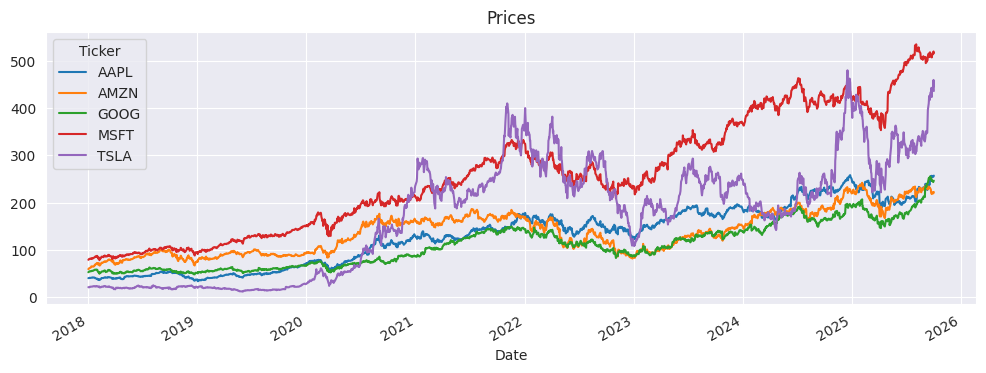

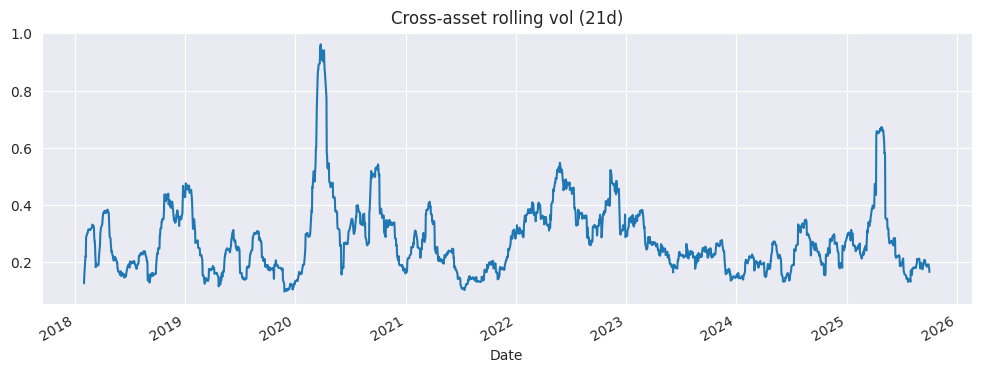

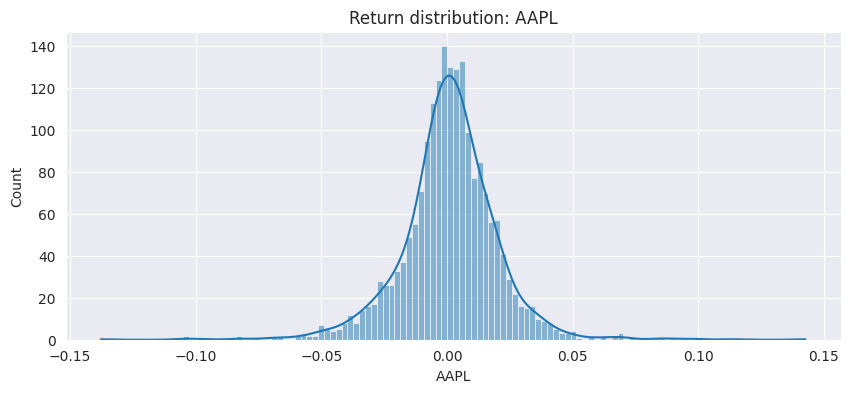

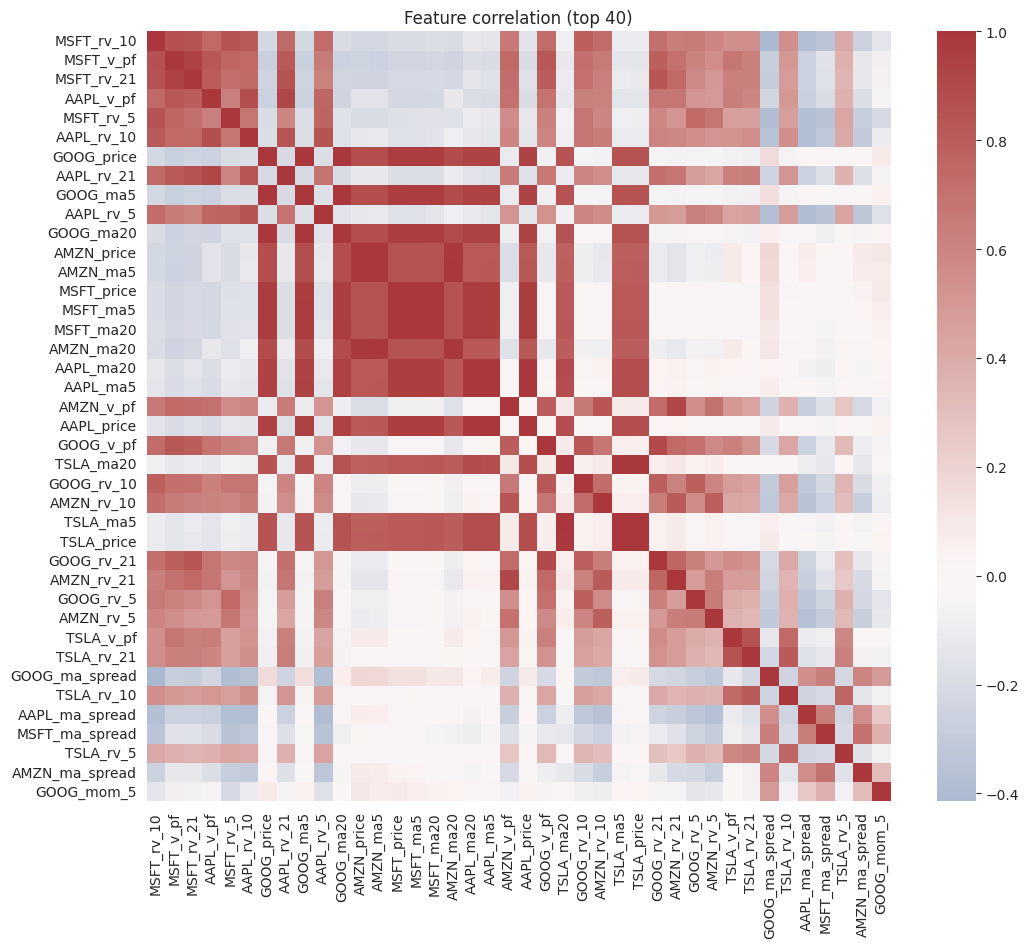

<Figure size 640x480 with 0 Axes>

In [14]:
def plot_eda(prices, rets, feats):
    print("Plotting EDA...")
    # prices
    prices.plot(figsize=(12,4), title="Prices"); plt.show()
    # average rolling vol
    rets.mean(axis=1).rolling(21).std().mul(np.sqrt(252)).plot(figsize=(12,4), title="Cross-asset rolling vol (21d)"); plt.show()
    # return hist (first ticker)
    plt.figure(figsize=(10,4))
    sns.histplot(rets[TICKERS[0]].dropna(), bins=120, kde=True)
    plt.title(f"Return distribution: {TICKERS[0]}"); plt.show()
    # feature corr (top subset)
    corr = feats.corr().abs()
    top_cols = corr.sum().sort_values(ascending=False).head(40).index
    plt.figure(figsize=(12,10))
    sns.heatmap(feats[top_cols].corr(), cmap="vlag", center=0, annot=False)
    plt.title("Feature correlation (top 40)"); plt.show()

plot_eda(prices, rets, feats)
#plt.savefig("Visualization Phase.png")

## Prepare X/y and scaling

In [15]:
X = feats.values
y = targets.values  # multi-output
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

## Machine Learning Model we're gonna use

In [16]:
class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2, output_dim=None):
        super().__init__()
        if output_dim is None:
            output_dim = len(TICKERS)
        layers = []
        in_dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, X):
        return self.net(X)

In [17]:
net = NeuralNetRegressor(
    MLPModule,
    module__input_dim=Xs.shape[1],
    module__output_dim=y.shape[1],
    max_epochs=60,
    lr=1e-3,
    batch_size=256,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    iterator_train__shuffle=False,
    device=DEVICE,
    verbose=0
)


## Randomized hyperparameter search (time-series CV)

In [18]:
param_dist = {
    "module__hidden_dim": [32,64,128,256],
    "module__num_layers": [1,2,3],
    "module__dropout": [0.0, 0.1, 0.2, 0.4],
    "lr": loguniform(1e-5, 1e-2),
    "max_epochs": randint(30, 120),
    "batch_size": [64, 128, 256]
}

tscv = TimeSeriesSplit(n_splits=N_TS_SPLITS)
search = RandomizedSearchCV(
    net,
    param_distributions=param_dist,
    n_iter=RANDOM_SEARCH_ITERS,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=1,  
    verbose=2,
    random_state=42
)

search.fit(Xs.astype(np.float32), y.astype(np.float32))
print("Best params:", search.best_params_)
best_model = search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END batch_size=256, lr=0.0024526126311336773, max_epochs=44, module__dropout=0.2, module__hidden_dim=256, module__num_layers=1; total time=  14.4s
[CV] END batch_size=256, lr=0.0024526126311336773, max_epochs=44, module__dropout=0.2, module__hidden_dim=256, module__num_layers=1; total time=   1.1s
[CV] END batch_size=256, lr=0.0024526126311336773, max_epochs=44, module__dropout=0.2, module__hidden_dim=256, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=2.9380279387035334e-05, max_epochs=112, module__dropout=0.2, module__hidden_dim=128, module__num_layers=3; total time=   3.2s
[CV] END batch_size=64, lr=2.9380279387035334e-05, max_epochs=112, module__dropout=0.2, module__hidden_dim=128, module__num_layers=3; total time=   6.1s
[CV] END batch_size=64, lr=2.9380279387035334e-05, max_epochs=112, module__dropout=0.2, module__hidden_dim=128, module__num_layers=3; total time=   6.0s
[CV] END batch_size=64, 

## Predictions and True Metrics

In [19]:
preds = best_model.predict(Xs.astype(np.float32))
preds_df = pd.DataFrame(preds, index=feats.index, columns=TICKERS)
true_df = pd.DataFrame(y, index=feats.index, columns=TICKERS)

In [20]:
def ml_metrics(y_true, y_pred):
    out = {}
    out['mse_by_asset'] = ((y_true - y_pred)**2).mean(axis=0)
    out['rmse_by_asset'] = np.sqrt(out['mse_by_asset'])
    out['mae_by_asset'] = np.abs(y_true - y_pred).mean(axis=0)
    out['r2_by_asset'] = [r2_score(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]
    out['directional_acc_by_asset'] = np.mean(np.sign(y_true) == np.sign(y_pred), axis=0)
    return out

metrics_ml = ml_metrics(y, preds)
print("ML metrics per asset:")
for i,t in enumerate(TICKERS):
    print(t, "RMSE:", metrics_ml['rmse_by_asset'][i], "MAE:", metrics_ml['mae_by_asset'][i],
          "R2:", metrics_ml['r2_by_asset'][i], "DirAcc:", metrics_ml['directional_acc_by_asset'][i])

ML metrics per asset:
AAPL RMSE: 0.01899748517773989 MAE: 0.01346421189095615 R2: 0.0663438432893455 DirAcc: 0.5288012454592631
MSFT RMSE: 0.021349020000679658 MAE: 0.015260319030101896 R2: 0.036377342251731726 DirAcc: 0.5573430202387131
GOOG RMSE: 0.019089826855988992 MAE: 0.013616576497585253 R2: 0.04838374561348158 DirAcc: 0.5552672548002076
AMZN RMSE: 0.017231584246172903 MAE: 0.012284583875694696 R2: 0.08974902975082344 DirAcc: 0.564608199273482
TSLA RMSE: 0.03902367715851068 MAE: 0.028261517090206478 R2: 0.06845796671314186 DirAcc: 0.5526725480020758


## Asset Allocation and Backtesting for Strategies

In [21]:
alloc_records = []
strat_returns = []
prev_w = np.zeros(len(TICKERS))
for i, dt in enumerate(preds_df.index):
    idx = prices.index.get_loc(dt)
    if idx < LOOKBACK_COV:
        alloc_records.append({"date": dt, **{f"w_{t}": 0.0 for t in TICKERS}})
        strat_returns.append(0.0)
        continue
    mu = preds_df.loc[dt].values
    window_rets = rets.iloc[(idx-LOOKBACK_COV):idx]
    Sigma = window_rets.cov().values
    try:
        invS = np.linalg.pinv(Sigma)
        w_raw = invS.dot(mu)
        if np.sum(np.abs(w_raw)) == 0:
            w = np.zeros_like(w_raw)
        else:
            w = w_raw / np.sum(np.abs(w_raw))
    except Exception:
        w = np.zeros(len(TICKERS))
    # realized next-day return vector (align with targets)
    real_next = true_df.iloc[i].values
    turnover = np.sum(np.abs(w - prev_w))
    tc_cost = turnover * TRANSACTION_COST_PER_TRADE
    strat_r = w.dot(real_next) - tc_cost
    strat_returns.append(strat_r)
    alloc_records.append({"date": dt, **{f"w_{t}": float(w[j]) for j,t in enumerate(TICKERS)}})
    prev_w = w.copy()

alloc_df = pd.DataFrame(alloc_records).set_index("date")
strat_ret_series = pd.Series(strat_returns, index=preds_df.index).dropna()

## Financial Metrics Section (In order to measure the model's credibility)

In [22]:
def annualize_return(returns, periods_per_year=252):
    total = (1 + returns).prod()
    n = len(returns)
    return total**(periods_per_year / n) - 1

def annualized_vol(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, rf=0.0, periods_per_year=252):
    ar = annualize_return(returns, periods_per_year)
    av = annualized_vol(returns, periods_per_year)
    return (ar - rf) / av if av != 0 else np.nan

def max_drawdown(returns):
    wealth = (1 + returns).cumprod()
    peak = wealth.cummax()
    drawdown = (wealth - peak) / peak
    return drawdown.min()

def sortino_ratio(returns, rf=0.0, periods_per_year=252):
    ar = annualize_return(returns, periods_per_year)
    negative = returns[returns < 0]
    downside = negative.std() * np.sqrt(periods_per_year) if len(negative) > 0 else 1e-9
    return (ar - rf) / downside

In [23]:
perf = {
    'annual_return': annualize_return(strat_ret_series),
    'annual_vol': annualized_vol(strat_ret_series),
    'sharpe': sharpe_ratio(strat_ret_series),
    'max_drawdown': max_drawdown(strat_ret_series),
    'sortino': sortino_ratio(strat_ret_series)
}
print("\nTrading performance:")
for k,v in perf.items():
    print(k, ":", v)


Trading performance:
annual_return : 0.39910054442232235
annual_vol : 0.14427192798034544
sharpe : 2.7663076941530367
max_drawdown : -0.12712576561105912
sortino : 4.825901864405856


## Explainability regarding Wealth, Biases, and Equity Turnover

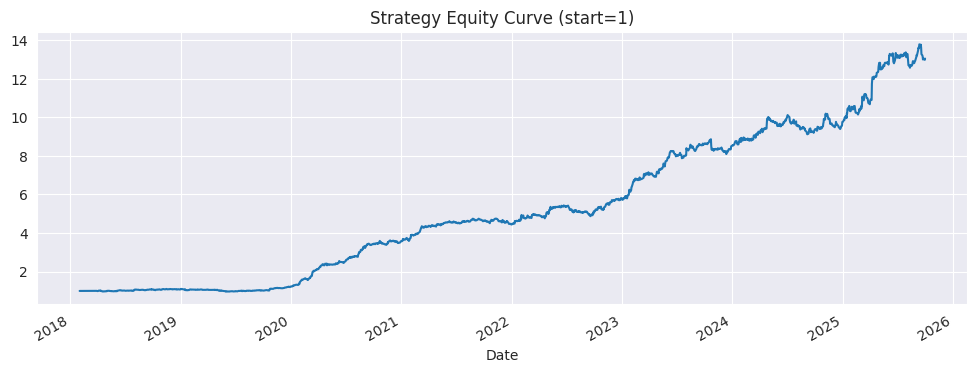

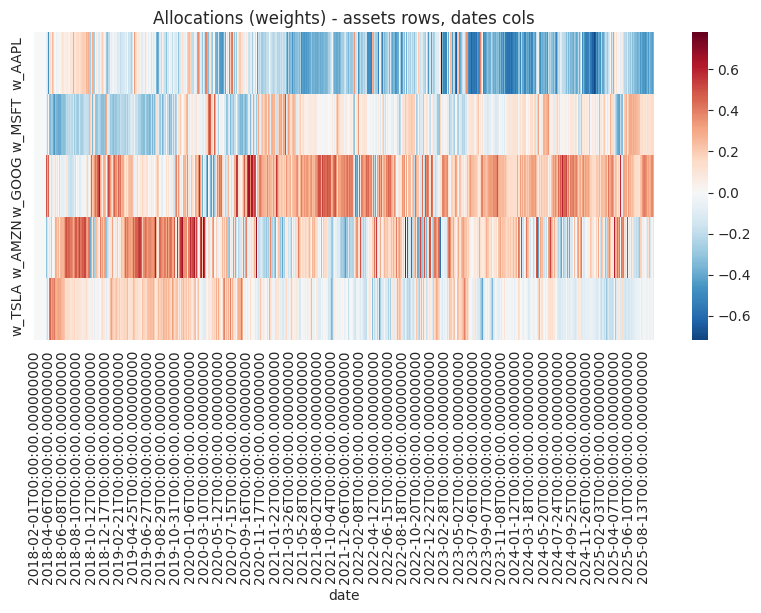

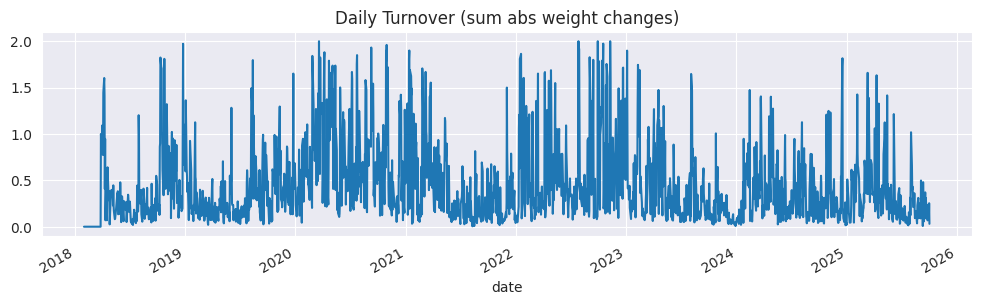

<Figure size 640x480 with 0 Axes>

In [25]:
wealth = (1 + strat_ret_series).cumprod()
plt.figure(figsize=(12,4)); wealth.plot(title="Strategy Equity Curve (start=1)"); plt.show()

plt.figure(figsize=(10,4))
sns.heatmap(alloc_df[[f"w_{t}" for t in TICKERS]].T, cmap="RdBu_r", center=0)
plt.title("Allocations (weights) - assets rows, dates cols"); plt.show()

turnover_series = alloc_df[[f"w_{t}" for t in TICKERS]].diff().abs().sum(axis=1)
plt.figure(figsize=(12,3)); turnover_series.plot(title="Daily Turnover (sum abs weight changes)"); plt.show()
#plt.savefig("Final Results of Modelling.png")


## Model Explainability Section (Where we learn how the model thinks)

PermutationExplainer explainer: 401it [01:36,  3.73it/s]                                                                


SHAP summary for 1st asset


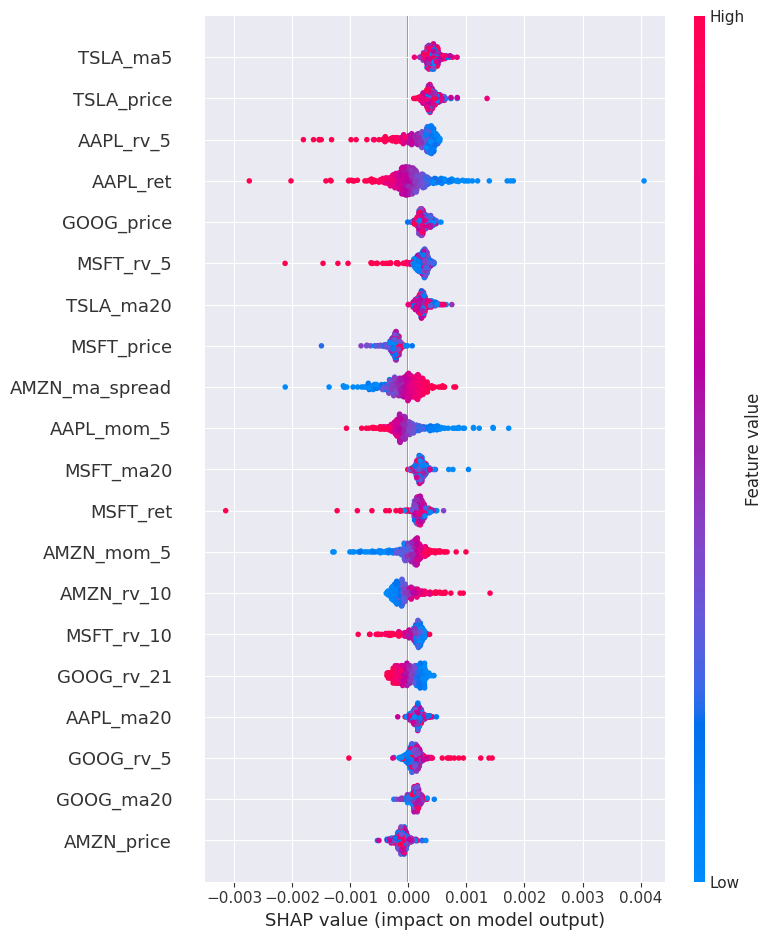

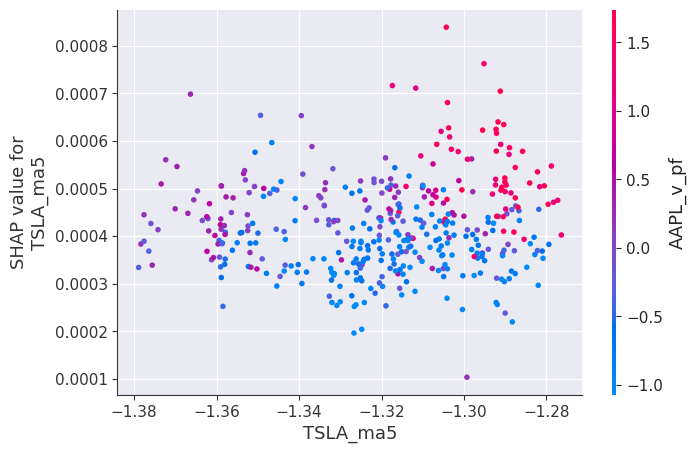

<Figure size 640x480 with 0 Axes>

In [27]:
def predict_for_shap(X_input):
    X_t = torch.tensor(X_input.astype(np.float32)).to(DEVICE)
    with torch.no_grad():
        preds = best_model.module_.forward(X_t).cpu().numpy()
    return preds

#using a small background fro better visualization
bg_idx = np.random.choice(len(Xs), size=min(200, len(Xs)), replace=False)
background = Xs[bg_idx]
explainer = shap.Explainer(predict_for_shap, background)
# limiting samples for speed 
sample_for_shap = Xs[:400]
shap_values = explainer(sample_for_shap)

if isinstance(shap_values.values, np.ndarray) and shap_values.values.ndim == 3:
    print("SHAP summary for 1st asset")
    shap.summary_plot(shap_values.values[:,:,0], features=sample_for_shap, feature_names=feats.columns)
else:
    shap.summary_plot(shap_values, features=sample_for_shap, feature_names=feats.columns)

# Top SHAP feature dependence example (1st asset)
if isinstance(shap_values.values, np.ndarray) and shap_values.values.ndim == 3:
    mean_abs = np.abs(shap_values.values[:,:,0]).mean(axis=0)
    top_idx = np.argsort(mean_abs)[-1]
    shap.dependence_plot(top_idx, shap_values.values[:,:,0], sample_for_shap, feature_names=feats.columns)
#plt.savefig("Model Explaination.png")

## Saving The Model and Potential Dataset Results

In [29]:
preds_df.to_csv("preds.csv")
alloc_df.to_csv("allocations.csv")

with open("NeuralHestonRegressor.pkl", "wb") as m:
    pickle.dump(best_model, m)

with open("ModelExplainer.pkl", "wb") as me:
    pickle.dump(explainer, me)